<a href="https://colab.research.google.com/github/Jameschen7/Digit_Recognition/blob/master/Digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit recognition competition

## Dataset Overview

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [0]:
# data_dir = "data"?
# train_fp = os.path.join(os.path.curdir, data_dir, "train.csv")
# test_fp = os.path.join(data_dir, "test.csv")
train_fp = "/content/drive/My Drive/Colab Notebooks/Digit Recognition/data/train.csv"
test_fp = "/content/drive/My Drive/Colab Notebooks/Digit Recognition/data/test.csv" 

In [0]:
train_fp

'/content/drive/My Drive/Colab Notebooks/Digit Recognition/data/train.csv'

In [0]:
train_df = pd.read_csv(train_fp)
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
dtype: int64

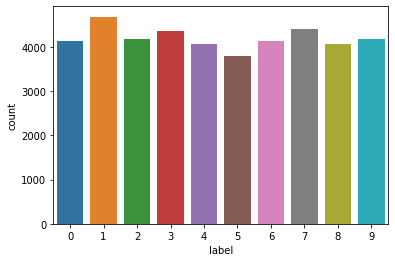

In [0]:
sns.countplot(train_df["label"])
train_df.groupby("label").size()

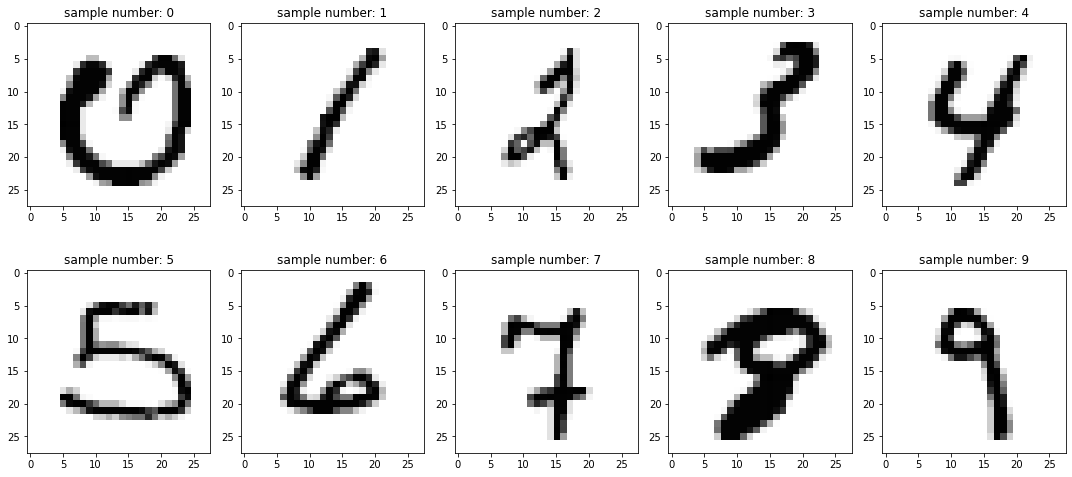

In [0]:
# example picture
sample_pixels = train_df.groupby("label").apply(lambda df: df.sample())
sample_pixels = sample_pixels.set_index("label")

fig, ax = plt.subplots(2,5, figsize=(15,7))
for i in range(10):
    pixel, label = sample_pixels.iloc[i].to_list(), sample_pixels.index[i]
    ax[i//5, i%5].imshow(np.reshape(pixel, (28, 28)), cmap="Greys")
    ax[i//5, i%5].set_title("sample number: %d" % i)
fig.tight_layout()
plt.show()

In [0]:
# data validity check: null and types
print("# of nulls: ", train_df.isnull().sum().sum())
print("types: ", train_df.dtypes.unique())

# of nulls:  0
types:  [dtype('int64')]


## Data Preprocessing

In [7]:
# extract and normalize features and labels
train_df = pd.read_csv(train_fp)
random_seed = 2 # Set the random seed for all remaining random_state

X_train = np.reshape(train_df.iloc[:, 1:].values / 255, (-1, 28, 28, 1))
Y_train_class = train_df["label"].values
Y_train = to_categorical(Y_train_class, num_classes=10, dtype=int)   # one-hot encoding

print(X_train.shape, Y_train.shape)

(42000, 28, 28, 1) (42000, 10)


In [8]:
# split training data into training and validation data

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (37800, 10) (4200, 10)


0    3721
1    4199
2    3774
3    3933
4    3611
5    3423
6    3724
7    3955
8    3681
9    3779
Name: train, dtype: int64

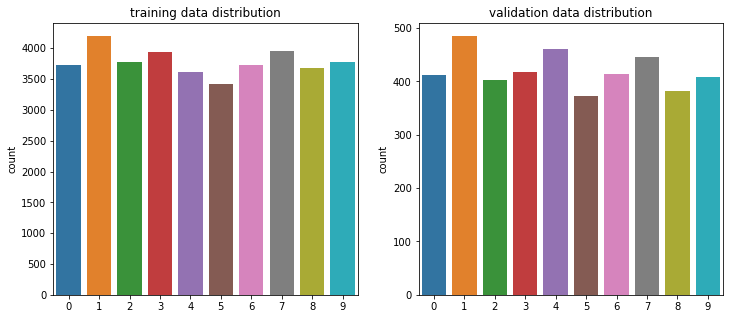

In [9]:
# training data distribution 
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.countplot(np.argmax(Y_train, axis=1), ax=axes[0])
sns.countplot(np.argmax(Y_val, axis=1), ax=axes[1])
axes[0].set_title("training data distribution")
axes[1].set_title("validation data distribution")
pd.Series(np.sum(Y_train, axis=0), name="train")
# pd.Series(np.sum(Y_val, axis=0))

## Data Augmentation

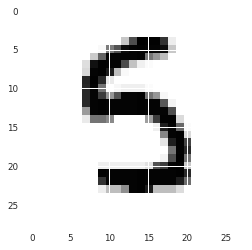

In [0]:
# take a look at a random digit to get an idea of how to augment the training dataset
example_index = np.random.randint(0, 42000)
plt.imshow(X_train[example_index][:,:,0], cmap="Greys")

In [0]:
# configure an image generator
datagen = ImageDataGenerator(
    width_shift_range=5,
    height_shift_range=4,
    rotation_range=13,
    # shear_range=1,
    zoom_range=0.1
)
# datagen.fit(X_train)

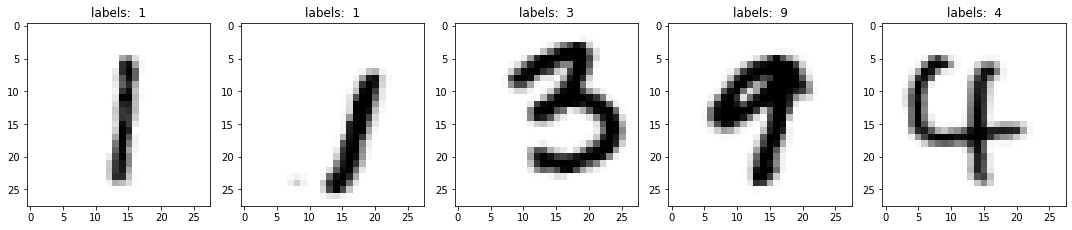

In [11]:
# Demonstrate the example images from data augmentation
example_number = 5
fig, ax = plt.subplots(1, example_number, figsize=[15,5])
it = datagen.flow(X_train, np.argmax(Y_train, axis=1), batch_size=1)
for i in range(example_number):
    example, example_label = it.next()
    # print(example.shape, example_label.shape)
    ax[i].imshow(example[0][:,:,0], cmap="Greys")
    ax[i].set_title("labels: % d" % example_label)
    print(it)
fig.tight_layout()

### Approach 1: Manually Generate a dataset with desired size and ratio

original shape:  (37800, 28, 28, 1)
1st augmented shape:  (75401, 28, 28, 1)
2nd augmented shape:  (85401, 28, 28, 1) label length:  (85401, 10)


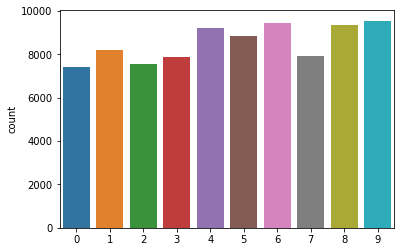

In [0]:
# manually augmenting the X_train into desired size and ratio
def generate_image(which, train, label, batch_size=500):
    train = train[np.argmax(label, axis=1) == which]
    label = label[np.argmax(label, axis=1) == which]
    it = datagen.flow(train, label, batch_size=batch_size)
    return it.next()
print("original shape: ", X_train.shape)

X_train_aug = np.copy(X_train)
Y_train_aug = np.copy(Y_train)
for i in range(10):
    new_train, new_label = generate_image(i, X_train, Y_train, 4000)
    X_train_aug = np.concatenate((X_train_aug, new_train), axis=0)
    Y_train_aug = np.concatenate((Y_train_aug, new_label), axis=0)
print("1st augmented shape: ", X_train_aug.shape)

important = [4, 5, 6, 8, 9] # the class with poorest accuracy based on the Analysis Result during the initial training without image data augmentation
for i in important:
    new_train, new_label = generate_image(i, X_train, Y_train, 2000)
    X_train_aug = np.concatenate((X_train_aug, new_train), axis=0)
    Y_train_aug = np.concatenate((Y_train_aug, new_label), axis=0)
print("2nd augmented shape: ", X_train_aug.shape, "label length: ", Y_train_aug.shape)

sns.countplot(np.argmax(Y_train_aug, axis=1))

In [0]:
# shuffle
X_train_aug, Y_train_aug = shuffle(X_train_aug, Y_train_aug, random_state=random_seed)
Y_train_aug

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

label:  2


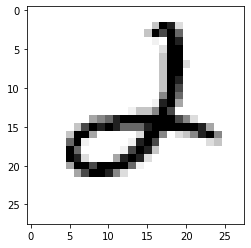

In [0]:
test_index = np.random.randint(-20000, 0)
plt.imshow(X_train_aug[test_index][:,:,0], cmap="Greys")
print("label: ", np.argmax(Y_train_aug[test_index]))

In [0]:
x = [[1,2,3], [1,2,4], [1,2,5]] + [[1,2,6]] 
print(x)
np.random.shuffle(x)
x

[[1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6]]


[[1, 2, 6], [1, 2, 3], [1, 2, 4], [1, 2, 5]]

In [0]:
Y_train_aug

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

### Approach 2: Conduct Data Augmentation on Real Time

In [0]:
# prepare for using the data generator at real training time
datagen.fit(X_train)
batch_size = 25
steps_per_epoch = X_train.shape[0] // batch_size  # number of batchs for each epoch

In [0]:
# create a data iterater to generate image data at real time
data_it = datagen.flow(X_train, Y_train, batch_size=batch_size)

## Model Building & Training
architecture: 

Input => 

Conv2d (relu) => Conv2d (relu) => MaxPool => Dropout => 

Conv2d (relu) => Conv2d (relu) => MaxPool => Dropout =>

Conv2d (relu) => MaxPool => Dropout =>

Flatten => Dense => Dropout = > Dense => Output

In [0]:
# build the layers in the model
model = Sequential()
model.add(Conv2D(32, (5,5), padding="same", activation="relu", use_bias=False, input_shape=(28,28,1)))
model.add(Conv2D(32, (5,5), padding="same", activation="relu", use_bias=False))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35, seed=random_seed))

model.add(Conv2D(64, (5,5), padding="same", activation="relu", use_bias=False))
model.add(Conv2D(64, (5,5), padding="same", activation="relu", use_bias=False))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3, seed=random_seed))

model.add(Conv2D(128, (5,5), padding="same", activation="relu", use_bias=False))
# model.add(Conv2D(128, (5,5), padding="same", activation="relu", use_bias=False))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25, seed=random_seed))

model.add(Flatten())
model.add(Dense(256,  activation="relu", use_bias=False))
model.add(Dropout(0.15, seed=random_seed))
model.add(Dense(256,  activation="relu", use_bias=False))
model.add(Dense(10,  activation="softmax", use_bias=False))

In [0]:
# also add learning rate schedule
lr_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.000001)

In [0]:
# compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
# training
epochs = 70
batch_size = 25

# approach 0: the naive way to train the model without data augmentation
# history = model.fit(x=X_train, y=Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

# approach 1: train the model with data augmentation
# history = model.fit(x=X_train_aug, y=Y_train_aug, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))  # train with the augmented data

# approach 2: train the model with data augmentation and a callback function defined by the ReduceRLOnPlateau from Keras
# history = model.fit(initial_epoch=50 ,x=X_train_aug, y=Y_train_aug, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[lr_reduction])  # train with the augmented data + callback

# approach 3: train the model with real-time data generation from data augmentation with learning rate schedules by ReduceRLOnPlateau
history = model.fit_generator(data_it, initial_epoch=0, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[lr_reduction])  # train with the augmented data + callback

# X_train_aug.shape, Y_train_aug.shape

Epoch 1/70
1512/1512 [==============================] - 22s 15ms/step - loss: 0.3528 - accuracy: 0.8854 - val_loss: 0.0567 - val_accuracy: 0.9819
Epoch 2/70
1512/1512 [==============================] - 16s 11ms/step - loss: 0.1102 - accuracy: 0.9690 - val_loss: 0.0424 - val_accuracy: 0.9867
Epoch 3/70
1512/1512 [==============================] - 16s 11ms/step - loss: 0.0911 - accuracy: 0.9751 - val_loss: 0.0374 - val_accuracy: 0.9881
Epoch 4/70
1512/1512 [==============================] - 16s 10ms/step - loss: 0.0785 - accuracy: 0.9790 - val_loss: 0.0457 - val_accuracy: 0.9890
Epoch 5/70
1512/1512 [==============================] - 16s 10ms/step - loss: 0.0762 - accuracy: 0.9790 - val_loss: 0.0351 - val_accuracy: 0.9907
Epoch 6/70
1512/1512 [==============================] - 16s 10ms/step - loss: 0.0679 - accuracy: 0.9820 - val_loss: 0.0421 - val_accuracy: 0.9902
Epoch 7/70
1512/1512 [==============================] - 16s 10ms/step - loss: 0.0648 - accuracy: 0.9829 - val_loss: 0.0331 -

best accuracy:  0.9964285492897034


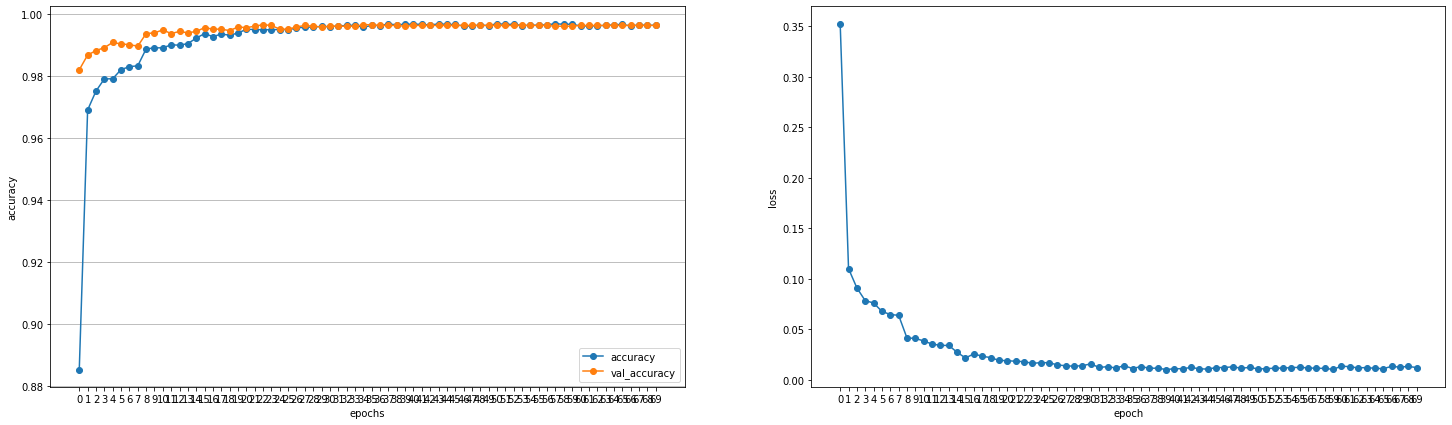

In [19]:
# check convergence and overfitting

fig, ax = plt.subplots(1,2, figsize=(25,7))
ax[0].plot(history.epoch, history.history["accuracy"], marker="o", label="accuracy")
ax[0].plot(history.epoch, history.history["val_accuracy"], marker="o", label="val_accuracy")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")
ax[0].legend()
ax[0].set_xticks(ticks=list(range(history.epoch[0], history.epoch[-1]+1)))
ax[0].grid(axis="y")

ax[1].plot(history.epoch, history.history["loss"], marker="o", label="loss")
ax[1].set_xticks(ticks=history.epoch)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")
print("best accuracy: ", max(history.history["val_accuracy"]))

### Result History
#### Initial

1. init: 0.99
2. conv2d bias=true: 0.987
3. dense bias=true: 0.986
4. v2 + drop+ conv2d: 0.989, 0.991
5. v3 + conv2d: 0.9902
6. v4 + maxpool2d + drop: 0.9907, 0.993
7. v4 with rmsprop: 0.99
8. v4 with batch=20: 0.989, 0.9933, 0.994
9. v5 + conv2d + drop: 0.9904, 0.9935, 0.9935
10. v5.1: 0.987, 0.993, 0.995
---
#### Adding another layer of conv2d, maxpool, and dropout:

11. v5: 0.9912, 0.991, 0.993
12. v6 + conv2d: 0.988, 0.9917, 0.9928
13. v5 0.2,0.1: 0.991, 0.9928
14. v7 - drop: 0.992, 0.9928, 0.993
15. v8 - dense: 0.993, 0.994, 0.9928, 0.9935

* **test accuracy: ~0.991**
---
#### Adding Data Augmentation:
16. v8 +aug: 0.992
17. v5 + aug.2: 0.992, 0.993
18. v5 + augmentation with ~30 epochs: 0,995

* **test accuracy: ~0.994**
---
#### Adding ReduceLROnPlateau: 

19. min_lr=0.0001: 0.9959
20. min_lr=0.00001: 0.9961

* **test accuracy: ~0.996**
---
#### Enable use_bias in layers
21. min_lr=0.00001 + bias + 512 neurons in the last dense layer: 0.997

* **test accuracy: 0.9951**
---
#### use fit_generator to train on augmented images from generator
22. min_lr=0.00001: 0.9959
23. min_lr=0.000005: 0.9971

* **test accuracy: 0.99614**
---
#### use grid search to hyper tune some parameters
24. min_lr=0.000005: 0.9967

* **test accuracy: 0.996**

---
#### use the intermediate between the previous parameters and the grid search best parameters:
25. intermediate + min_lr=0.000001: 0.9962

* **test accuracy: 0.99614**


## Grid Search Hyperparameters Optimization
This section will use the gridSearchCV from scikit-learn library to tune hyperparameters in Keras CNN models.

In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import adam

In [0]:
np.random.seed(random_seed)
print(X_train.shape, Y_train.shape)
print(random_seed)

(37800, 28, 28, 1) (37800, 10)
2


In [0]:
# create a function which builds a model for the KerasClassifier wrapper class
def create_model(third_layer=[128], kernel_size=(5,5), dropout1=0.3, dropout2=0.25, dropout3=0.2, dropout4=0.1, lr=0.001):
    model = Sequential()
    model = Sequential()
    model.add(Conv2D(32, kernel_size, padding="same", activation="relu", use_bias=False, input_shape=(28,28,1)))
    model.add(Conv2D(32, kernel_size, padding="same", activation="relu", use_bias=False))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout1, seed=random_seed))

    model.add(Conv2D(64, kernel_size, padding="same", activation="relu", use_bias=False))
    model.add(Conv2D(64, kernel_size, padding="same", activation="relu", use_bias=False))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout2, seed=random_seed))

    for single_size in third_layer:
    # if len(third_layer) == 1:
        model.add(Conv2D(third_layer[0], kernel_size, padding="same", activation="relu", use_bias=False))
    # model.add(Conv2D(128, kernel_size, padding="same", activation="relu", use_bias=False))
    # model.add(Conv2D(128, (5,5), padding="same", activation="relu", use_bias=False))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout3, seed=random_seed))

    model.add(Flatten())
    model.add(Dense(256,  activation="relu", use_bias=False))
    model.add(Dropout(dropout4, seed=random_seed))
    model.add(Dense(256,  activation="relu", use_bias=False))
    model.add(Dense(10,  activation="softmax", use_bias=False))
    # Compile model
    optimizer = adam(lr)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
# model = KerasClassifier(build_fn=create_model, verbose=0)
model = KerasClassifier(build_fn=create_model, kernel_size=(3,3), batch_size=20, epochs=5, lr=0.001)
param_grid = dict(
    # batch_size=[10, 20, 30],
    # batch_size=[20],
    # epochs=[10],
    third_layer=[(128,), (128, 256)], # some sklearn issue with nested array: https://github.com/keras-team/keras/issues/13586#issuecomment-586634246
    # third_layer=[(128,)],
    # kernel_size=[(3,3), (5,5)],
    dropout1 = [0.35],
    dropout2 = [0.3],
    dropout3 = [0.2, 0.3],
    dropout4 = [0.2, 0.3],
)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=None,  n_jobs=-1, cv=3)

In [0]:
grid_result = grid.fit(X_train, Y_train, verbose=1)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/5
37800/37800 [==============================] - 10s 266us/step - loss: 0.2493 - accuracy: 0.9175
Epoch 2/5
37800/37800 [==============================] - 10s 263us/step - loss: 0.0880 - accuracy: 0.9739
Epoch 3/5
37800/37800 [==============================] - 10s 264us/step - loss: 0.0684 - accuracy: 0.9802
Epoch 4/5
37800/37800 [==============================] - 10s 263us/step - loss: 0.0597 - accuracy: 0.9826
Epoch 5/5
37800/37800 [==============================] - 10s 264us/step - loss: 0.0509 - accuracy: 0.9860
Best: 0.988624 using {'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0.2, 'dropout4': 0.3, 'third_layer': (128,)}


In [0]:
pd.set_option('display.max_colwidth', -1)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
value = dict(
    # params = grid_result.cv_results_["params"],
    params = grid_result.cv_results_["params"],
    means = grid_result.cv_results_["mean_test_score"],
    stds = grid_result.cv_results_["std_test_score"]
)
param_comp = pd.DataFrame(data=value).sort_values(by=["means", "stds"], ascending=[False, True], ignore_index=True)
param_comp

Best: 0.988307 using {'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0.2, 'dropout4': 0.3, 'lr': 0.001, 'third_layer': (128,)}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,params,means,stds
0,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0.2, 'dropout4': 0.3, 'lr': 0.001, 'third_layer': (128,)}",0.988307,0.000714
1,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0.3, 'dropout4': 0, 'lr': 0.001, 'third_layer': (128,)}",0.988175,0.000683
2,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0.2, 'dropout4': 0, 'lr': 0.001, 'third_layer': (128,)}",0.987857,0.001043
3,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0.3, 'dropout4': 0.2, 'lr': 0.001, 'third_layer': (128,)}",0.987831,0.001384
4,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0.3, 'dropout4': 0.3, 'lr': 0.001, 'third_layer': (128,)}",0.987778,0.000747
5,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0, 'dropout4': 1, 'lr': 0.001, 'third_layer': (128,)}",0.987169,0.001332
6,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0, 'dropout4': 0, 'lr': 0.001, 'third_layer': (128,)}",0.987090,0.001344
7,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 1, 'dropout4': 0.2, 'lr': 0.001, 'third_layer': (128,)}",0.986931,0.001938
8,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 1, 'dropout4': 1, 'lr': 0.001, 'third_layer': (128,)}",0.986667,0.001912
9,"{'dropout1': 0.35, 'dropout2': 0.3, 'dropout3': 0.2, 'dropout4': 1, 'lr': 0.001, 'third_layer': (128,)}",0.986534,0.002330


In [0]:
for i in param_comp["params"]:
    print(i)
# param_comp.loc[1,"params"]

## Analysis Result

total missing:  16


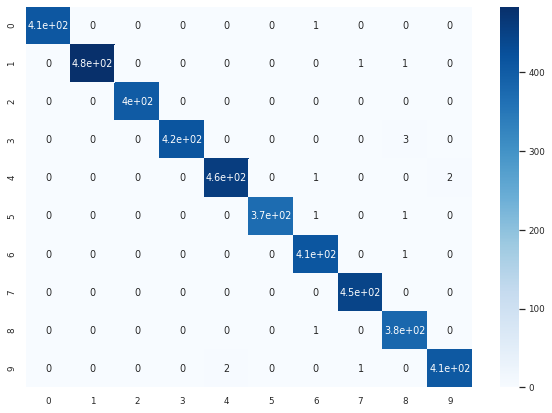

In [20]:
# print the confusion matrix for the model evaluated on the validation data

Y_predict_class = np.argmax(model.predict(X_val), axis=1)
# Y_predict_class = np.argmax(model.predict(X_train_aug), axis=1)

cm = confusion_matrix(np.argmax(Y_val, axis=1), Y_predict_class)  # C(i,j) = # of labels i classified as j
# cm = confusion_matrix(np.argmax(Y_train_aug, axis=1), Y_predict_class)
plt.figure(figsize = (10,7))
sns.set(font_scale=0.8) # for label size
sns.heatmap(pd.DataFrame(cm, index=pd.RangeIndex(10), columns=pd.RangeIndex(10)) , annot=True, cmap=plt.cm.Blues)
print("total missing: ", (np.argmax(Y_val, axis=1) != Y_predict_class).sum())

In [21]:
# print the total missing for each digit

Y_val_class = np.argmax(Y_val, axis=1)
# Y_val_class = np.argmax(Y_train_aug, axis=1)
result = pd.DataFrame({"true":Y_val_class, "predict":Y_predict_class})
missing_by_label = result.groupby("true").apply(lambda df: (df["true"] != df["predict"]).sum()).to_frame().rename(columns={0:"count"})
missing_by_label

,count
true,
0,1
1,2
2,0
3,3
4,3
5,2
6,1
7,0
8,1


In [22]:
X_val.shape

(4200, 28, 28, 1)

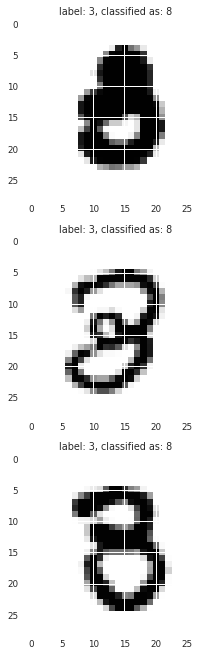

In [23]:
## print some confusing figures that defeat the model:

Y_predict_class = np.argmax(model.predict(X_val), axis=1)
Y_val_class = np.argmax(Y_val, axis=1)
worst_label = missing_by_label["count"].argmax()
error_index = (Y_predict_class != Y_val_class) & (Y_val_class == worst_label)
error_pixel = X_val[error_index, :, :, 0]
error_label = Y_predict_class[error_index]

num = error_index.sum()
fig, axes = plt.subplots(num, 1, figsize=(3, num*3), constrained_layout=True)
for i in range(num):
    axes[i].imshow(error_pixel[i], cmap="Greys")
    axes[i].set_title("label: %d, classified as: %d" % (worst_label, error_label[i]))

# ax[i].imshow(example[0][:,:,0], cmap="Greys")
#     ax[i].set_title("labels: % d" % example_label)
# error_label

## Prediction on Test Data & Submission

In [24]:
test_df = pd.read_csv(test_fp)
X_test = np.reshape(test_df.values / 255, (-1, 28, 28, 1))

test_prediction = np.argmax(model.predict(X_test), axis=1)
test_result_sr = pd.DataFrame({"ImageId": np.arange(1, len(test_prediction)+1), "Label": test_prediction})
test_result_sr

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [0]:
output_fp = os.path.join("/content/drive/My Drive/Colab Notebooks/Digit Recognition/data/submission.csv")
test_result_sr.to_csv(output_fp, index=False)

## Remarks

* The digit 4 and the digit 9 often confuse the model and appear in the analysis result section, but it should be reasonable as a closer look at those failing images will reveal the difficulty for classification even for humans.

* On the other side, the digit 5 constantly appears in the failing list, and it is easy for the model to confuse 5 with 3, 6, 8, .... One possible explanation is that the digit 5 has the least amount of data for training and validation as shown in the analysis in the Dataset Overview sections.

# Reference:
* Kaggle recommended notebook for CNN introduction on digit recognization:
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook#2.-Data-preparation

* Image Data Preprocessing: https://github.com/ctwayen/Digit-Recognizer

* Learning rate schedules by ReduceRLOnPlateau: https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

* Tune hyperparameter using gridSearchCV from sklearn: 
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
